# Fraud Detection

In this project, we'll be building a classification model that aims to detect fraud in credit card transactions. This type of task usually deals with extremely imbalanced datasets, so we'll also be looking into dealing with those. Without further ado, let's check out our dataset.

In [ ]:
#import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

In [ ]:
credit_card = pd.read_csv("/kaggle/input/creditcardfraud/creditcard.csv")
credit_card.head()

The dataset that we have today consists of 31 variables, including our target variable: Class. 0 represents not fraud and 1 represents fraud. The remaining variables consist of Time, Amount and 28 V variables. The V variables are the result of a PCA (dimensionality reduction) transformation in order to protect customer information. So in this project, we wouldn't have the details to present a very interpretable result. Rather, we'll focus on the methods and evaluations we can adopt to deal with imbalanced datasets.

In [ ]:
credit_card.describe()

We can see that only Time and Amount have drastically different scales from the other variables. We'll have to scale them later.

# EDA

First, let's perform a simple EDA on our dataset.

**Target Variable: Class**

In [ ]:
sns.countplot(x=credit_card["Class"])

In [ ]:
credit_card["Class"].value_counts()

We can see the extreme imbalance between the two classes of our target variable. This dataset is an accurate reflection of real-world dataset. Obviously, most credit card transactions are not going to be fraud.

**Time and Amount**

In [ ]:
sns.histplot(data=credit_card, x="Time")

In [ ]:
sns.histplot(data=credit_card, x="Amount", bins=500)

We can also see that variables Time and Amount have odd distributions. Amount is especially skewed, so it's important that we transform them later.

# Train Test Split

But first, let's split the data into training and testing before we do anything else.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
y = credit_card.Class
X = credit_card.drop('Class', axis=1)

In [ ]:
#split so that the proportions of imbalance remains the same in the training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

We'll split the training and testing dataset such that the proportions of class 1 and class 0 are the same in both the training and testing dataset.

In [ ]:
#training dataset proportion
y_train.value_counts(normalize=True)

In [ ]:
#testing dataset proportion
y_test.value_counts(normalize=True)

# Data Preprocessing

Next, we'll be scaling Time and Amount. We'll be using the PowerTransfomer to help us automatically scale and normalize the two variables

In [ ]:
from sklearn.preprocessing import PowerTransformer

In [ ]:
#instantiate power transformer
pt_amount = PowerTransformer()

#transform amount 
X_train['Amount_scaled'] = pt_amount.fit_transform(X_train['Amount'].values.reshape(-1,1))
sns.histplot(data=X_train, x="Amount_scaled", bins=100)

In [ ]:
#instantiate power transformer
pt_time = PowerTransformer()

#transform time
X_train['Time_scaled'] = pt_time.fit_transform(X_train['Time'].values.reshape(-1,1))
sns.histplot(data=X_train, x="Time_scaled", bins=100)

In [ ]:
#drop origianl time and amount
X_train = X_train.drop(['Time', 'Amount'], axis=1)
X_train.head()

**Apply transformation to testing data**

Perfect, then we apply the PowerTransformer to our testing dataset as well. (The reason we do this seperately is to prevent data leakage)

In [ ]:
#transform Amount and Time for testing data
X_test['Amount_scaled'] = pt_amount.transform(X_test['Amount'].values.reshape(-1,1))
X_test['Time_scaled'] = pt_time.transform(X_test['Time'].values.reshape(-1,1))

X_test = X_test.drop(['Time', 'Amount'], axis=1)

Perfect! Now that we've performed some basic data preprocessing, let's move on to experiment with different methods of dealing with imbalanced data.

# Imbalanced Data

Imbalanced datasets are a pain to deal with, but some models intrinsically perform better with imbalanced data than others. Typically tree-based and boosting algorithms perform better with imbalanced data. Boosting models are especially ideal as higher weight is given to the minority class at each iteration. We'll see how they perform.

**Good for Imbalanced Dataset**
- Decision Tree
- Random Forest
- Adaboost
- Gradient Boosting

**Bad for Imbalanced Dataset**
- Logistics Regression
- Support Vector Classifier
- Naives Bayes

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, f1_score

Let's start by building a logistic regression model as our baseline model.

In [ ]:
#build logistics regression model
log_reg = LogisticRegression()

log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

log_reg_accuracy = accuracy_score(y_test, y_pred)
print("Logistics Regression Accuracy: ", log_reg_accuracy)

#create confusion matrix
cm = confusion_matrix(y_test, y_pred)

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #ftm='g' to disable scientific notation

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Not Fraud', 'Fraud']); ax.yaxis.set_ticklabels(['Not Fraud', 'Fraud']);

If we were to look at accuracy as our evaluating metric, we can see that logistic regression performed extraordinarily well at 99.9%. But this is often the flaw with imbalanced dataset. Even if the classification model classifies everything as the majority class, the model would achieve high accuracy. So when dealing with imbalanced dataset, we have to look at other metrics. In most cases, we prefer to look at the F-1 score, which is the harmonic mean between precision and recall.

In [ ]:
#print classification report
print(classification_report(y_test, y_pred))

Based on the confusion matrix and classification report above, we can see that the logistics regression model achieved a precision of 0.86 and a recall of 0.62 for class 1. This means that while 86% of its fraud predictions were correct, it only captured 62% of the fraud transactions. In real-life, this recall may be too low. Our primary objective is to identify as much fraud transactions as possible.

# Precision-Recall Tradeoff

To identify more fraud transactions, what we could do is we could adjust the decision threshold for logistics regression. Eeach sample is assigned a probability (of it being fraud) by the logistic regression model. The decisive threshold is, by default, 0.5. We can lower that threshold so that more samples are predicted as fraud (therefore capable of capturing more actual frauds).

In [ ]:
#change threshold to 0.2
y_pred_new = (log_reg.predict_proba(X_test)[:,1]>=0.2).astype(int)

#build confusion matrix
cm = confusion_matrix(y_test, y_pred_new)

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax); 

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Not Fraud', 'Fraud']); ax.yaxis.set_ticklabels(['Not Fraud', 'Fraud']);

In [ ]:
print(classification_report(y_test, y_pred_new))

As we can see above, by lowering the decision threshold to 0.2, we were able to increase our recall from 0.62 to 0.71, meaning we were able to capture an additional 9% of fraud transactions. This achievement, however, does not come without a cost. As we tried to predict more transactions as fraud, we also misclassified more non-fraud transactions as fraud, decreasing the precision (0.86 -> 0.79). Thus, we can observe a trade-off relationship between precision and recall.

We don't want either one of the value (precision and recall) to be too low, so we must strive for a balance between the two. Thankfully, that is exactly what F-1 score is designed to do. The F-1 score is the harmonic mean between recall and precision. So from now on, we will use F1-score as our main evaluation metric.

In the example of logistic regression, the F-1 score for a threshold=0.2 is greater than that of the default threshold (0.5). Therefore, if we were to use logistic regression as our model, it will be better to set the threshold around 0.2.

# RandomForest

Next, let's try using a model that is intrinisically better at dealing with imbalanced datasets. We'll start with RandomForest.

In [ ]:
#build randomforest model
rfm = RandomForestClassifier(random_state=42)

rfm.fit(X_train, y_train)
rfm_pred = rfm.predict(X_test)

#build confusion matrix
rfm_cm = confusion_matrix(y_test, rfm_pred)

ax= plt.subplot()
sns.heatmap(rfm_cm, annot=True, fmt='g', ax=ax);

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Not Fraud', 'Fraud']); ax.yaxis.set_ticklabels(['Not Fraud', 'Fraud']);

In [ ]:
print(classification_report(y_test, rfm_pred))

Wow! We can see that RandomForest performed much better than logistics regression! The F-1 score is much higher. Also note that this model is being built without any tuning and addresses to the imbalanced target variable yet.

# Adaboost

Next, let's try adaboost.

In [ ]:
#build adaboost classifier
ada = AdaBoostClassifier(random_state=42)

ada.fit(X_train, y_train)
ada_pred = ada.predict(X_test)

#build confusion matrix
ada_cm = confusion_matrix(y_test, ada_pred)

ax= plt.subplot()
sns.heatmap(ada_cm, annot=True, fmt='g', ax=ax);

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Not Fraud', 'Fraud']); ax.yaxis.set_ticklabels(['Not Fraud', 'Fraud']);

In [ ]:
print(classification_report(y_test, ada_pred))

Turns out Adaboost didn't perform very well in this particular case. We probably could improve the model's performance by tuning and playing around with the parameters, but RandomForest seems to be the better choice here.

# Gradient Boosting

In [ ]:
#build gradient boosting
gb = GradientBoostingClassifier(random_state=42)

gb.fit(X_train, y_train)
gb_pred = gb.predict(X_test)

#build confusion matrix
gb_cm = confusion_matrix(y_test, gb_pred)

ax= plt.subplot()
sns.heatmap(gb_cm, annot=True, fmt='g', ax=ax);

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Not Fraud', 'Fraud']); ax.yaxis.set_ticklabels(['Not Fraud', 'Fraud']);

In [ ]:
print(classification_report(y_test, gb_pred))

Wow! GradientBoosting actually performed horribly! We can see that the F-1 score is super low. It almost feels like it's not predicting any fraud transactions at all. Let's just resort to using RandomForest.

# Oversampling, Undersampling, SMOTE

Now, let's move on to dealing with imbalanced data. The three most popular ways to treat imbalanced data is oversampling, undersampling and SMOTE. We will demonstrate and try all three to compare which method works out the best in this scenario.

> When we resample our data, remember it's important that you only resample the training data and not the testing data. Build your model using the resampled data and then test it with the untouched testing data.

In [ ]:
from sklearn.utils import resample

In [ ]:
#double check the counts of 0 and 1s
y_train.value_counts()

In [ ]:
# concatenate our training data back together
X_concat = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_fraud = X_concat[X_concat.Class==0]
fraud = X_concat[X_concat.Class==1]

**Oversampling**

In [ ]:
# oversample fraud transaction (minority)
fraud_oversampled = resample(fraud, replace=True, n_samples=len(not_fraud), random_state=42) # with replacement

# combine majority and oversampled minority
oversampled = pd.concat([not_fraud, fraud_oversampled])

#split X and y
y_train_oversampled = oversampled.Class
X_train_oversampled = oversampled.drop('Class', axis=1)

# check new class counts
oversampled.Class.value_counts()

**Undersampling**

In [ ]:
# undersample not fraud (majority)
not_fraud_undersampled = resample(not_fraud, replace=False, n_samples=len(fraud), random_state=42) #without replacement

# combine undersampled majority and minority
undersampled = pd.concat([not_fraud_undersampled, fraud])

#split X and y
y_train_undersampled = undersampled.Class
X_train_undersampled = undersampled.drop('Class', axis=1)

# check new class counts
undersampled.Class.value_counts()

**SMOTE**

In [ ]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)

X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

y_train_sm.value_counts()

# Oversampling

Now that we have equalized the imbalanced ratio of our target variable, we'll try RandomForest again to see if we can observe an improvement.

In [ ]:
#RFM with oversampled data
rfm_OS = RandomForestClassifier(random_state=42)

rfm_OS.fit(X_train_oversampled, y_train_oversampled)
rfm_OS_pred = rfm_OS.predict(X_test)

#build confusion matrix
rfm_OS_cm = confusion_matrix(y_test, rfm_OS_pred)

ax= plt.subplot()
sns.heatmap(rfm_OS_cm, annot=True, fmt='g', ax=ax); 

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Not Fraud', 'Fraud']); ax.yaxis.set_ticklabels(['Not Fraud', 'Fraud']);

In [ ]:
print(classification_report(y_test, rfm_OS_pred))

Based on F-1 score, training RF on an oversampled data does not exceed the performance of the initial RF model. 

# Undersampling

In [ ]:
#RFM with undersampled data
rfm_US = RandomForestClassifier(random_state=42)

rfm_US.fit(X_train_undersampled, y_train_undersampled)
rfm_US_pred = rfm_US.predict(X_test)

#build confusion matrix
rfm_US_cm = confusion_matrix(y_test, rfm_US_pred)

ax= plt.subplot()
sns.heatmap(rfm_US_cm, annot=True, fmt='g', ax=ax);

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Not Fraud', 'Fraud']); ax.yaxis.set_ticklabels(['Not Fraud', 'Fraud']);

In [ ]:
print(classification_report(y_test, rfm_US_pred))

Undersampling seems to do even worse than oversampling. We can see that precision dropped to 0.05 in exchange for a relatively high recall at 0.90. This leads to a low f1-score. Although we were able to identify 90% of the fraud transactions, the predictions are not precise at all.

# SMOTE

In [ ]:
#RFM with SMOTE
rfm_sm = RandomForestClassifier(random_state=42)

rfm_sm.fit(X_train_sm, y_train_sm)
rfm_sm_pred = rfm_sm.predict(X_test)

#build confusion matrix
rfm_sm_cm = confusion_matrix(y_test, rfm_sm_pred)

ax= plt.subplot()
sns.heatmap(rfm_sm_cm, annot=True, fmt='g', ax=ax);

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Not Fraud', 'Fraud']); ax.yaxis.set_ticklabels(['Not Fraud', 'Fraud']);

In [ ]:
print(classification_report(y_test, rfm_sm_pred))

The results from SMOTE is also pretty good. Although the F-1 score was not as high as the initial RF model, the recall is higher. In turn, the precision is still within acceptable range, so not too bad.

# Model Comparison

Finally, let's put everything together to compare the different statistics of the four RFM that we built.

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

#model dictionary
predicted_values = {"RandomForest": rfm_pred, "RandomForest OS": rfm_OS_pred, "RandomForest US": rfm_US_pred, "RandomForest SMOTE": rfm_sm_pred}

#create df
df = pd.DataFrame(columns=['model', 'precision', 'recall', 'f1_score'])

#plug precision recall and f1score into the dataframe for each model
for key, value in predicted_values.items():
    precision = precision_recall_fscore_support(y_test, value, average=None)[0][1]
    recall = precision_recall_fscore_support(y_test, value, average=None)[1][1]
    f1_score = precision_recall_fscore_support(y_test, value, average=None)[2][1]
    df = df.append({'model': key, 'precision':precision, 'recall':recall, 'f1_score':f1_score}, ignore_index=True)

df = df.set_index('model')
df.head()

Again, we can see that the f1_score is the highest for the initial RandomForest model (without any treatments to the imbalanced dataset). The first model, however, has a relatively higher precision than its recall. In many cases of imbalanced dataset (like this with fraud detection), we should be willing to sacrifice some precision for better recall. Therefore, RandomForest with SMOTE also seems like a pretty good choice. RandomForest US would be way too extreme as it sacrificed way too much precision for a little increase in recall.

# ROC and AUC

Finally, let's take a look at another evaluation metric ROC and AUC, and see if we can extract some insights.

In [ ]:
#change figure size
plt.figure(figsize=(10, 10))

# RFM SMOTE
rfm_sm_probas = rfm_sm.predict_proba(X_test)[:,1]
fpr, tpr, threshold = roc_curve(y_test, rfm_sm_probas)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', linewidth=3, label = 'SMOTE AUC = %0.4f' % roc_auc)

#RFM Undersampled
rfm_US_probas = rfm_US.predict_proba(X_test)[:,1]
fpr, tpr, threshold = roc_curve(y_test, rfm_US_probas)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'g', linewidth=3, label = 'US AUC = %0.4f' % roc_auc)

#RFM Oversampled
rfm_OS_probas = rfm_OS.predict_proba(X_test)[:,1]
fpr, tpr, threshold = roc_curve(y_test, rfm_OS_probas)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'r', linewidth=3, label = 'OS AUC = %0.4f' % roc_auc)

#RFM
rfm_probas = rfm.predict_proba(X_test)[:,1]
fpr, tpr, threshold = roc_curve(y_test, rfm_probas)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'purple', linewidth=3, label = 'Nth AUC = %0.4f' % roc_auc)

#plot horizontal line at y=0.9 and y=0.99
plt.axhline(y=0.9, color = 'black', linestyle='dashed', linewidth=3)
plt.axhline(y=0.99, color = 'black', linestyle='dashed', linewidth=3)

plt.title('RFM Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

We can see from the comparison of the ROC curves for the four different models. For those who always gets confused by TPR and FPR (confusing terms) like I do, let's give it a quick review:

* True Positive Rate (sensitivity): Out of all fraud cases, the amount that is classified as fraud
* False Positive Rate (1-specificity): Out of all non-fraud cases, the amount that is classified as fraud

> Again, we have a trade-off relationship between the two. Which model is better ultimately comes down to what is the minimum TPR that you're willing to accept. We can see that if we can accept a TPR of 0.9 (90% of all fraud captured), then RF with SMOTE may be best because it achieves that TPR with the lowest FPR (bottom dashed horizontal line). But if we want to achieve a TPR of 0.99 (99% of all fraud captured), then RF with Undersampling is the best. (top dashed horizontal line)

But be aware that in the case of an imbalanced dataset, even a false positive rate of just 0.2 means a very low precision. This is due to the extreme difference in the majority and minority class. We can see this being the case for RF with Undersampling.

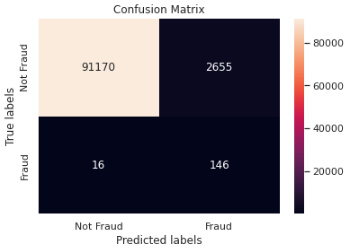

The FPR is only 0.03 here (2555/(91170+2555), but we can see that the precision dropped significantly. A small portion of the majority class could still be huge when compared to the minority class.